# Simulate the data

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import dirichlet, multinomial
from scipy.sparse import lil_matrix
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer

np.random.seed(37)

# number of topics
K = 10
# number of words
N = 100
# number of documents
M = 1000

# priors on K topics
a = np.array([0.1, 0.2, 0.3, 0.4, 0.025, 0.015, 0.37, 0.88, 0.03, 0.08])
# priors on N words
b = np.full((1, N), 0.001, dtype=float)[0]

# distribution of words in topic k
psi = np.array([dirichlet.rvs(b)[0] for _ in range(K)])

# distribution of topics in document d
theta = np.array([dirichlet.rvs(a)[0] for _ in range(M)])

# simulate the documents
texts = []
docs = []
for i in range(M):
    d = {}
    t = []
    for j in range(N):
        z_ij = multinomial.rvs(1, theta[i] / theta[i].sum())
        topic = np.argmax(z_ij)
        
        w_ij = multinomial.rvs(1, psi[topic] / psi[topic].sum())
        word = np.argmax(w_ij)
        
        if word not in d:
            d[word] = 0
        d[word] = d[word] + 1
        t.append('w{}'.format(word))
    docs.append(d)
    texts.append(' '.join(t))

# make a nice matrix
X = lil_matrix((M, N), dtype=np.int16)
for i, d in enumerate(docs):
    counts = sorted(list(d.items()), key=lambda tup: tup[0])
    for tup in counts:
        X[i, tup[0]] = tup[1]
        
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X)

# Look at the distribution

In [2]:
means = X.mean(axis=0)
means = [(i, means[0, i]) for i in range(means.shape[1]) if means[0, i] > 0.0]

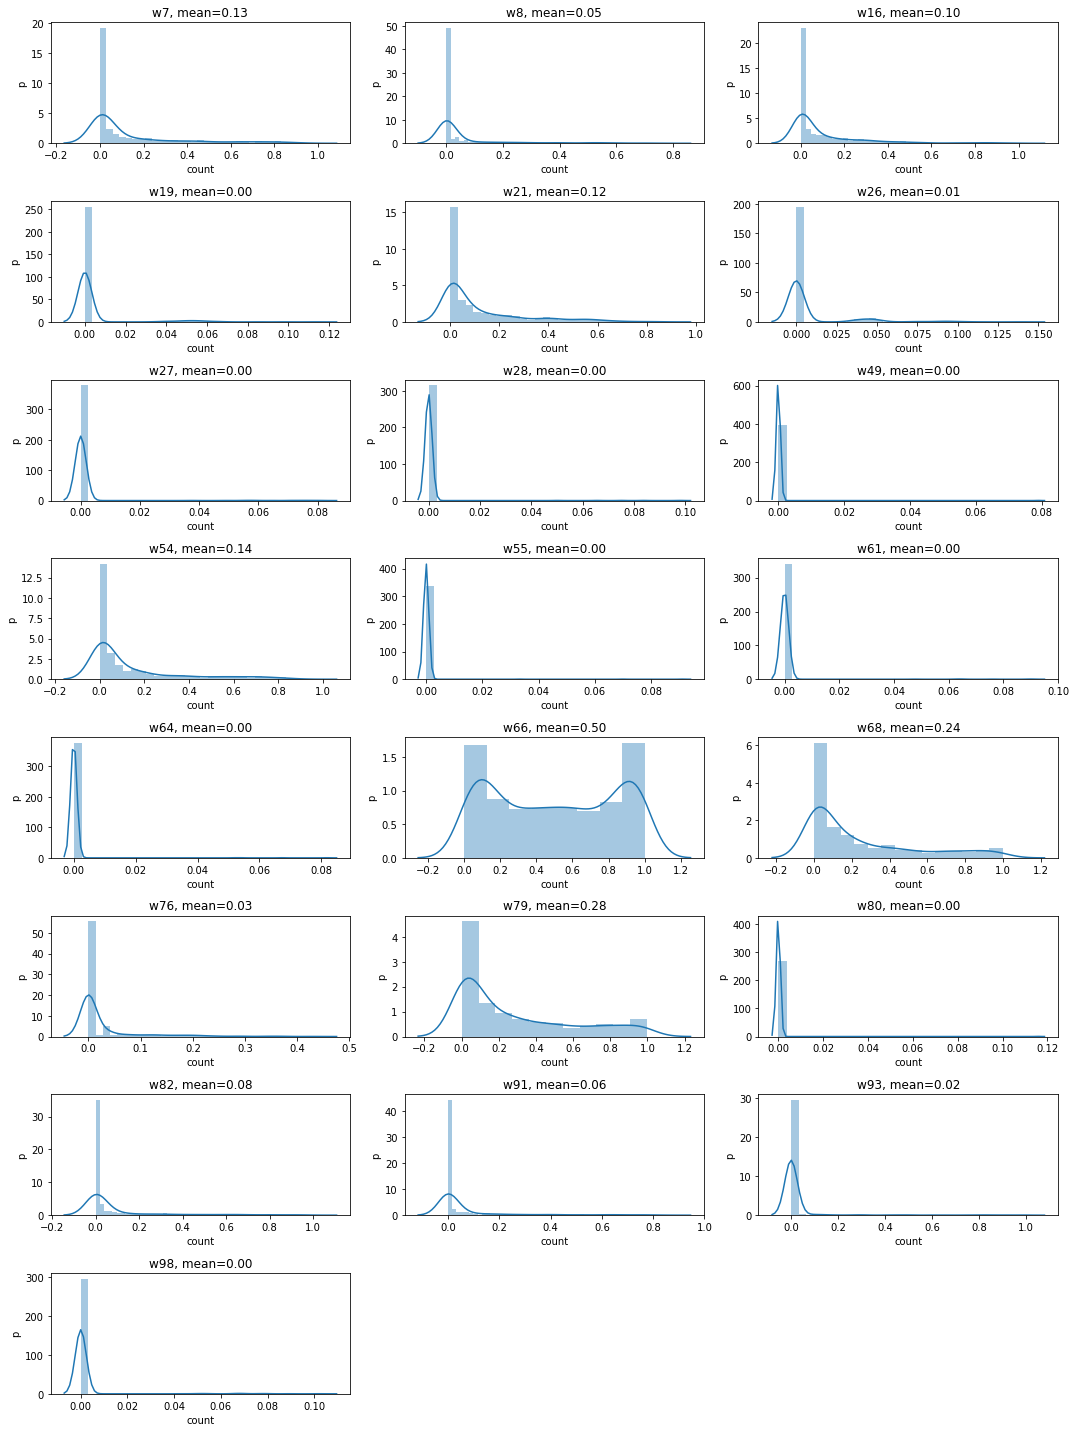

In [3]:
import math

n = len(means)
n_cols = 3
n_rows = math.ceil(n / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 20))
ax = np.ravel(ax)

for i in range(len(ax)):
    if i < len(means):
        idx = means[i][0]
        mu = means[i][1]
        data = X[:,idx].toarray().reshape(1, -1)[0]
        sns.distplot(data, ax=ax[i])
        ax[i].set_title('w{}, mean={:.2f}'.format(idx, mu))
        ax[i].set_ylabel('p')
        ax[i].set_xlabel('count')
    else:
        ax[i].axis('off')

plt.tight_layout()

# Look at the pairwise correlations

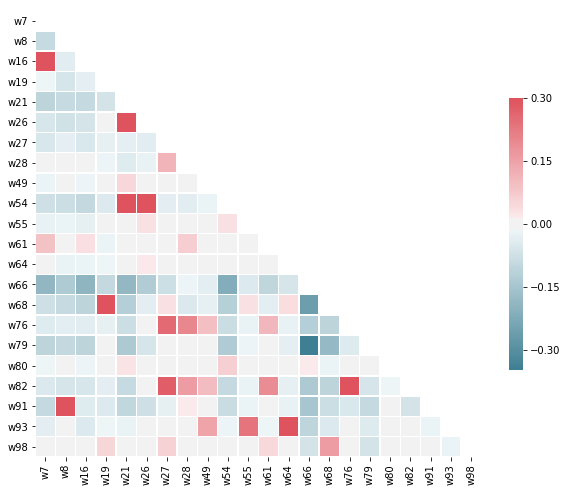

In [4]:
indices = sorted([tup[0] for tup in means])
df = pd.DataFrame(X[:, indices].toarray(), columns=['w{}'.format(i) for i in indices])
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Gaussian mixture models

In [5]:
from scipy.sparse.linalg import svds

U, S, V = svds(X, k=20)

In [6]:
from sklearn.mixture import GaussianMixture

def get_gmm_labels(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=200, random_state=37)
    gmm.fit(X)
    aic = gmm.aic(X)
    bic = gmm.bic(X)
    print('{}: aic={}, bic={}'.format(k, aic, bic))
    return aic, bic, k, gmm

gmm_scores = [get_gmm_labels(U, k) for k in range(2, 26)]

2: aic=-91377.49259316867, bic=-89115.01740955791
3: aic=-115401.4806469117, bic=-112005.31399385606
4: aic=-140093.33933540212, bic=-135563.48121290162
5: aic=-140323.7898736967, bic=-134660.2402817513
6: aic=-141875.7608870872, bic=-135078.51982569695
7: aic=-148775.55233751476, bic=-140844.61980667964
8: aic=-144864.34044251143, bic=-135799.7164422314
9: aic=-145063.4922621097, bic=-134865.17679238482
10: aic=-150715.19037698946, bic=-139383.1834378197
11: aic=-152996.52348895592, bic=-140530.8250803413
12: aic=-155759.2488041081, bic=-142159.8589260486
13: aic=-154738.52657589043, bic=-140005.44522838606
14: aic=-155298.3570419237, bic=-139431.58422497445
15: aic=-155273.8626619089, bic=-138273.39837551478
16: aic=-158229.54424744562, bic=-140095.38849160663
17: aic=-158801.92826365872, bic=-139534.08103837486
18: aic=-158146.9310716485, bic=-137745.39237691974
19: aic=-157399.8820983788, bic=-135864.65193420518
20: aic=-158964.20247723104, bic=-136295.28084361256
21: aic=-156443.2

Text(0.5,1,'AIC vs k')

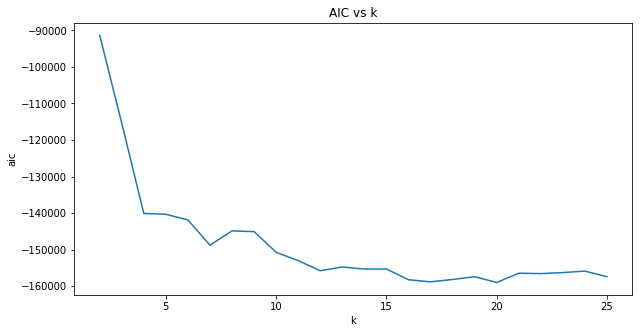

In [7]:
_x = [s[2] for s in gmm_scores]
_y = [s[0] for s in gmm_scores]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(_x, _y, color='tab:blue')
ax.set_xlabel('k')
ax.set_ylabel('aic')
ax.set_title('AIC vs k')

In [8]:
gmm = gmm_scores[14][3]

# k-means clustering

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_kmc(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    print('{}: score={}'.format(k, score))
    return score, k, model

kmc_scores = [get_kmc(X, k) for k in range(2, 26)]

2: score=0.22136552497539078
3: score=0.2606191325546754
4: score=0.2985364557161296
5: score=0.32764563696557253
6: score=0.34711980577628615
7: score=0.36212754809252495
8: score=0.3693035922796191
9: score=0.3118628444238988
10: score=0.32070416934016466
11: score=0.3056882384904699
12: score=0.28297903762485543
13: score=0.28462816984240946
14: score=0.2747613933318139
15: score=0.2787478862359055
16: score=0.27452088253304896
17: score=0.2548015324435892
18: score=0.25961952207924777
19: score=0.25650479556223627
20: score=0.251690199350559
21: score=0.2566617758778615
22: score=0.25866268014756943
23: score=0.24607465357359543
24: score=0.24936289940720038
25: score=0.2579644562276278


Text(0.5,1,'Silhouette vs k')

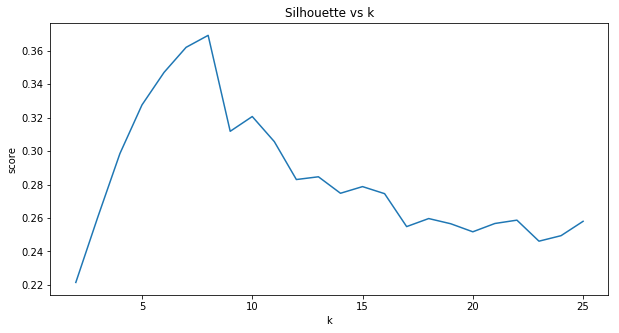

In [10]:
_x = [s[1] for s in kmc_scores]
_y = [s[0] for s in kmc_scores]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(_x, _y, color='tab:blue')
ax.set_xlabel('k')
ax.set_ylabel('score')
ax.set_title('Silhouette vs k')

# Topic modeling

In [11]:
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LsiModel, LdaModel, HdpModel

def dict_to_text(d):
    def convert(p):
        w = 'w{} '.format(p[0])
        s = w * p[1]
        s = s.strip()
        return s
    
    pairs = list(d.items())
    return ' '.join([convert(p) for p in pairs])
        
T = [t.split(' ') for t in texts]

dictionary = corpora.Dictionary(T)
corpus = [dictionary.doc2bow(text) for text in T]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [12]:
lsi = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=15)
corpus_lsi = lsi[corpus_tfidf]
print(lsi.get_topics().shape)

(15, 22)


In [14]:
lda = LdaModel(corpus, 
               id2word=dictionary, 
               num_topics=15, 
               random_state=37, 
               iterations=100,
               passes=5,
               per_word_topics=False)
corpus_lda = lda[corpus]
print(lda.get_topics().shape)

(15, 22)


In [15]:
hdp = HdpModel(corpus_tfidf, id2word=dictionary)
corpus_hdp = hdp[corpus_tfidf]
print(hdp.get_topics().shape)

(150, 22)


In [16]:
lda.print_topics(5)

[(1,
  '0.419*"w93" + 0.274*"w66" + 0.105*"w21" + 0.101*"w79" + 0.060*"w54" + 0.028*"w68" + 0.003*"w64" + 0.003*"w55" + 0.002*"w7" + 0.002*"w26"'),
 (4,
  '0.506*"w82" + 0.231*"w66" + 0.127*"w76" + 0.104*"w79" + 0.016*"w21" + 0.007*"w54" + 0.004*"w16" + 0.001*"w8" + 0.001*"w7" + 0.001*"w68"'),
 (9,
  '0.633*"w16" + 0.149*"w79" + 0.058*"w68" + 0.045*"w66" + 0.034*"w21" + 0.030*"w54" + 0.024*"w82" + 0.012*"w7" + 0.008*"w76" + 0.002*"w93"'),
 (0,
  '0.474*"w66" + 0.141*"w54" + 0.138*"w68" + 0.099*"w21" + 0.067*"w79" + 0.016*"w91" + 0.015*"w82" + 0.015*"w7" + 0.014*"w16" + 0.010*"w8"'),
 (5,
  '0.511*"w54" + 0.374*"w21" + 0.041*"w66" + 0.028*"w79" + 0.016*"w26" + 0.010*"w82" + 0.007*"w7" + 0.006*"w68" + 0.003*"w16" + 0.002*"w76"')]

In [17]:
lda.get_topics().shape

(15, 22)

In [18]:
for d in corpus_lsi:
    print(d)
    break

[(0, 0.6319407911602397), (1, -0.6876861913998322), (2, 0.21090712063657588), (3, 0.24885738690437598), (4, 0.11431371784540034), (5, -0.006792044158067494), (6, -0.03973880716386097), (7, -0.018971768308812243), (8, -0.07373476993501767), (9, 0.001169030431217053), (10, -0.00111153320045391), (11, -0.005194386672537657), (12, 0.002358487378802926), (13, -0.02776184771717828), (14, -0.005293831317634063)]


In [19]:
for i, d in enumerate(corpus_lda):
    for d_t in d:
        print(d_t)
    print('>')
    if i == 2:
        break

(6, 0.51050556)
(10, 0.48091355)
>
(0, 0.20216128)
(3, 0.25947762)
(6, 0.15248764)
(10, 0.3786127)
>
(3, 0.507928)
(11, 0.48349115)
>


In [20]:
for d in corpus_hdp:
    print(d)
    break

[(48, 0.6409534619980439)]


In [21]:
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/super/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Notes

* numpy 1.16.4
* scipy 1.3.0
* gensim 3.4.0